In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torch
import random
from pytorchtools import EarlyStopping

In [7]:
df = pd.read_csv("~/python_project/data/AI_dataset/data_by_all_20230518.csv")

In [8]:
#월별 co2 data 생성
co2 = df[['ID', 'co2(ppm)']]

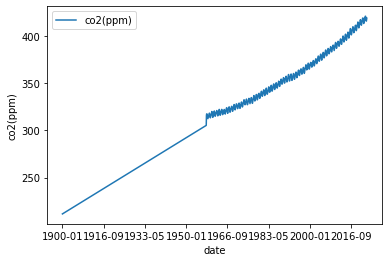

In [9]:
#x축 ID(1900-01 ~ 2022-12), y축이 co2인 그래프 생성
co2.set_index(df['ID']).plot()
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.show()

In [10]:
#ID를 연, 월로 분리하고 int로 형변환해 [연, 월] 형태의 리스트 생성
date_strings = np.array([date.split('-') for date in co2['ID']])
dates = []
for date_string in date_strings:
    date = [int(val) for val in date_string]
    dates.append(date)

In [11]:
#input: 연 월, output(target): co2
X = np.array(dates)
y = co2['co2(ppm)'].values

In [12]:
#input dimesion과 batch size, sequence 길이 설정
seq_length = 12
input_size = X.shape[1]
batch_size = 4

In [13]:
#원하는 sequence만큼 data를 이어줌 (num_data,sequence_length, input_size)형태)
def data_to_seq(data, input_size, seq_length):
    data_seq = np.array([])
    for i in range(0, data.shape[0] - (seq_length - 1)):
        data_seq = np.append(data_seq, data[i:i + seq_length])
    return data_seq.reshape(-1, seq_length, input_size)

In [14]:
#Minmax scaler를 통해 normalize
#나올 수 있는 모든 값들이 random하게 선택되었다는 가정하에 전체 데이터셋에 대하여 scaling 진행
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [15]:
#input data를 sequential하게 이어줌
X_seq = data_to_seq(data = X_scaled, input_size = input_size,seq_length = seq_length)

In [16]:
#train, validation, test set 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq[:-1], y[seq_length:], test_size = 0.4, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

In [17]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)
y_test = torch.FloatTensor(y_test)

In [18]:
train = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train, batch_size = batch_size, shuffle=True)

validation = TensorDataset(X_val, y_val)
valid_dataloader = DataLoader(validation, batch_size = batch_size, shuffle=False)

test = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test, batch_size = batch_size, shuffle=False)

In [19]:
#LSTM
class LSTM_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.lstm(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)

In [20]:
#RNN
class RNN_model(torch.nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_layers):
        super(RNN_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.rnn_layer = torch.nn.RNN(
            input_size = self.input_size,
            hidden_size = self.hidden_size, 
            num_layers = self.num_layers, 
            batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, output_size) 
    def forward(self,x):
        x = x.to(device)
        y, hidden = self.rnn_layer(x)
        y = y[:,-1, :]
        y = self.fc(y)
        return y.view(-1)

In [21]:
#GRU
class GRU_model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = x.to(device)
        y, hidden = self.gru(x)
        y = y[:,-1,:]
        y = self.fc(y)
        return y.view(-1)


In [22]:
def validation(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0
    num_batch = len(dataloader)
    with torch.no_grad():
        for x, y_true  in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            val_loss += loss.item()
    val_loss /= num_batch
    return val_loss

In [23]:
def train(model, dataloader, eval_dataloader, loss_fn, optim, epochs, device, patience, verbose = False):
    early_stopping = EarlyStopping(patience = patience, verbose = verbose)
    num_batch = len(dataloader)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y_true in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)
            train_loss += loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
        train_loss /= num_batch
        val_loss = validation(model, eval_dataloader, loss_fn, device)
        
        #patience만큼의 epoch동안 validation loss가 줄어들지 않을 시 early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f'Early stopping, Epoch: {epoch}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}')
            break
        if epoch % 20 == 0:
            print(f'Epoch: {epoch}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}')
    return train_loss

In [36]:
# learning late, hidden size, layer 수, output dimesion, epoch, device, patience, verbose 설정
# patience: early stopping을 결정하는 validation loss가 연속해서 줄어들지 않는 epoch 수
# verbose: True면 epoch마다 validation loss가 얼마나 줄었는지 출력됨
lr = 0.001
hidden_size = 10
num_layers = 1
output_size = 1
epochs = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
patience = 10
verbose = False

In [46]:
#RNN 모델
model_1 = RNN_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_1 = torch.nn.MSELoss().to(device)
optim_1 = torch.optim.Adam(params=model_1.parameters(), lr = lr )


In [38]:
#LSTM 모델
model_2 = LSTM_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_2 = torch.nn.MSELoss().to(device)
optim_2 = torch.optim.Adam(params=model_2.parameters(), lr = lr )

In [39]:
#GRU 모델
model_3 = GRU_model(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_3 = torch.nn.MSELoss().to(device)
optim_3 = torch.optim.Adam(params=model_3.parameters(), lr = lr )

In [47]:
#RNN 모델 training
train(model = model_1, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_1, 
      optim = optim_1, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 71922.09158381, Validation Loss: 72641.21801098
Epoch: 40, Train Loss: 49957.78607955, Validation Loss: 50522.47051837
Epoch: 60, Train Loss: 32332.74898349, Validation Loss: 32860.20290065
Epoch: 80, Train Loss: 19177.30304066, Validation Loss: 19576.35511739
Epoch: 100, Train Loss: 10170.43182262, Validation Loss: 10541.62835630
Epoch: 120, Train Loss: 5201.84564875, Validation Loss: 5487.80252694
Epoch: 140, Train Loss: 2013.77496206, Validation Loss: 2180.01125399
Epoch: 160, Train Loss: 678.11415376, Validation Loss: 762.09635625
Epoch: 180, Train Loss: 210.13723894, Validation Loss: 248.22941694
Epoch: 200, Train Loss: 62.21241946, Validation Loss: 74.91954611
Epoch: 220, Train Loss: 19.30223708, Validation Loss: 23.15314617
EarlyStopping counter: 1 out of 10
Epoch: 240, Train Loss: 8.71325294, Validation Loss: 10.21196268
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of

4.3987301904369485

In [41]:
#LSTM 모델 training
train(model = model_2, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_2, 
      optim = optim_2, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 71940.30340909, Validation Loss: 72620.15947002
Epoch: 40, Train Loss: 49880.45180220, Validation Loss: 50497.53322952
Epoch: 60, Train Loss: 32321.19414063, Validation Loss: 32843.14323796
Epoch: 80, Train Loss: 19146.60676824, Validation Loss: 19561.73782926
Epoch: 100, Train Loss: 10175.53871647, Validation Loss: 10534.57303028
Epoch: 120, Train Loss: 4812.75547105, Validation Loss: 5066.65773025
Epoch: 140, Train Loss: 1922.48712328, Validation Loss: 2087.65684802
Epoch: 160, Train Loss: 649.77014774, Validation Loss: 729.53501250
Epoch: 180, Train Loss: 181.21638102, Validation Loss: 215.19734644
Epoch: 200, Train Loss: 44.59537673, Validation Loss: 54.52080309
Epoch: 220, Train Loss: 11.77936308, Validation Loss: 15.53619424
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
Epoch: 240, Train Loss: 5.08811011, Validation Loss: 6.194868

2.84584862745621

In [42]:
#GRU 모델 training
train(model = model_3, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_3, 
      optim = optim_3, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 71749.91618430, Validation Loss: 72437.16160790
Epoch: 40, Train Loss: 49745.66257102, Validation Loss: 50349.98912584
Epoch: 60, Train Loss: 32202.39897017, Validation Loss: 32726.83058620
Epoch: 80, Train Loss: 19013.45542325, Validation Loss: 19474.04753649
Epoch: 100, Train Loss: 10144.46294361, Validation Loss: 10473.50816383
Epoch: 120, Train Loss: 5108.86010492, Validation Loss: 5250.08183260
Epoch: 140, Train Loss: 1940.79182660, Validation Loss: 2107.79621234
Epoch: 160, Train Loss: 654.07160149, Validation Loss: 733.28414687
Epoch: 180, Train Loss: 184.33799276, Validation Loss: 218.06385519
Epoch: 200, Train Loss: 43.13488746, Validation Loss: 52.94120990
Epoch: 220, Train Loss: 10.71134551, Validation Loss: 13.70922422
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
Epoch: 240, Train Loss: 4.51672200, Validation Loss: 6.20057360
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 

2.4197810042056846

In [48]:
#RNN 모델 test loss
print(f'model_1(RNN) Test Loss: {validation(model_1, test_dataloader, loss_func_1, device):.8f}')

model_1(RNN) Test Loss: 3.77216406


In [44]:
#LSTM 모델 test loss
print(f'model_2(LSTM) Test Loss: {validation(model_2, test_dataloader, loss_func_2, device):.8f}')

model_2(LSTM) Test Loss: 2.24510713


In [45]:
#GRU 모델 test loss
print(f'model_3(GRU) Test Loss: {validation(model_3, test_dataloader, loss_func_3, device):.8f}')

model_3(GRU) Test Loss: 2.05032639


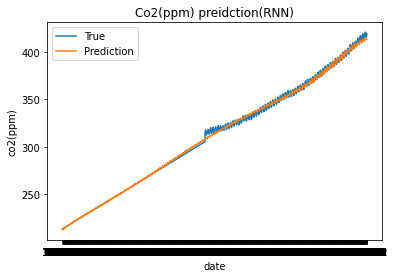

In [51]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 RNN모델 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length:],co2['co2(ppm)'][seq_length:], label = 'True')
plt.plot(co2.ID.values[seq_length:], model_1(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(RNN)')
plt.legend()
plt.show()

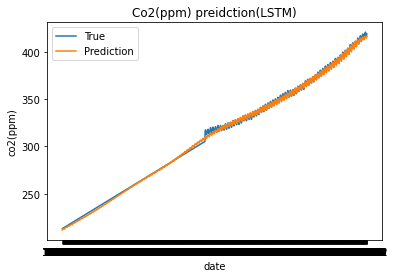

In [52]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 LSTM모델 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length:],co2['co2(ppm)'][seq_length:], label = 'True')
plt.plot(co2.ID.values[seq_length:], model_2(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(LSTM)')
plt.legend()
plt.show()

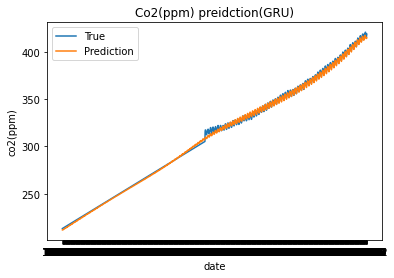

In [53]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 GRU모델 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length:],co2['co2(ppm)'][seq_length:], label = 'True')
plt.plot(co2.ID.values[seq_length:], model_3(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(GRU)')
plt.legend()
plt.show()

In [54]:
#RNN, LSTM, GRU을 ensemble한 model
class Ensemble_Model_1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Ensemble_Model_1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.rnn_model = RNN_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x = x.to(device)
        output_gru = self.gru_model(x)
        output_rnn = self.rnn_model(x)
        output_lstm = self.lstm_model(x)
        output = torch.vstack((output_rnn, output_lstm))
        output = torch.vstack((output, output_gru))
        output = torch.mean(output, dim = 0)

        return output

In [55]:
#LSTM, GRU을 ensemble한 model
class Ensemble_Model_2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Ensemble_Model_2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru_model = GRU_model(input_size, hidden_size, output_size, num_layers)
        self.lstm_model = LSTM_model(input_size, hidden_size, output_size, num_layers)

    def forward(self, x):
        x = x.to(device)
        output_gru = self.gru_model(x)
        output_lstm = self.lstm_model(x)
        output = torch.vstack((output_gru, output_lstm))
        output = torch.mean(output, dim = 0)

        return output

In [56]:
#Ensemble(RNN, LSTM, GRU)
model_4 = Ensemble_Model_1(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_4 = torch.nn.MSELoss().to(device)
optim_4 = torch.optim.Adam(params=model_4.parameters(), lr = lr )

In [57]:
#Ensemble(RNN, LSTM, GRU) 모델 training
train(model = model_4, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_4,
      optim = optim_4, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 71890.93327415, Validation Loss: 72570.07012774
Epoch: 40, Train Loss: 49948.26606889, Validation Loss: 50463.07556482
Epoch: 60, Train Loss: 32386.58933771, Validation Loss: 32819.32220624
Epoch: 80, Train Loss: 19112.17027699, Validation Loss: 19544.90417975
Epoch: 100, Train Loss: 10176.19637812, Validation Loss: 10525.44340619
Epoch: 120, Train Loss: 4814.04123903, Validation Loss: 5061.36860131
Epoch: 140, Train Loss: 1916.50231414, Validation Loss: 2079.03110286
Epoch: 160, Train Loss: 640.56104014, Validation Loss: 722.34779494
Epoch: 180, Train Loss: 177.47422192, Validation Loss: 213.19833342
Epoch: 200, Train Loss: 40.30464922, Validation Loss: 50.88647575
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
Epoch: 220, Train Loss: 13.15066684, Validation Loss: 11.52158006
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 o

1.9831440230503425

In [58]:
#Ensemble(RNN, LSTM, GRU) 모델 test loss
print(f'model_4(Ensemble(RNN, LSTM, GRU)) Test Loss: {validation(model_4, test_dataloader, loss_func_4, device):.8f}')

model_4(Ensemble(RNN, LSTM, GRU)) Test Loss: 2.20453723


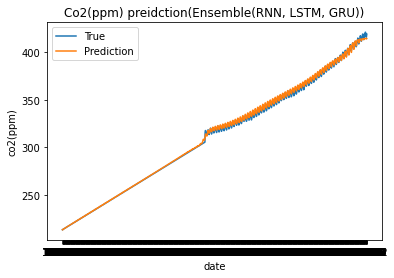

In [63]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 Ensemble모델(RNN, LSTM, GRU) 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length:],co2['co2(ppm)'][seq_length:], label = 'True')
plt.plot(co2.ID.values[seq_length:], model_4(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(Ensemble(RNN, LSTM, GRU))')
plt.legend()
plt.show()

In [59]:
#Ensemble(LSTM, GRU)
model_5 = Ensemble_Model_2(input_size, hidden_size, output_size, num_layers).to(device)
loss_func_5 = torch.nn.MSELoss().to(device)
optim_5 = torch.optim.Adam(params=model_5.parameters(), lr = lr )

In [60]:
#Ensemble(LSTM, GRU) 모델 training
train(model = model_5, dataloader = train_dataloader, eval_dataloader = valid_dataloader, loss_fn = loss_func_5, 
      optim = optim_5, epochs = epochs, device = device, patience = patience, verbose = verbose)

Epoch: 20, Train Loss: 71663.37400568, Validation Loss: 72372.86758340
Epoch: 40, Train Loss: 49695.51604226, Validation Loss: 50300.20346812
Epoch: 60, Train Loss: 32216.04011896, Validation Loss: 32690.99973606
Epoch: 80, Train Loss: 19012.57238381, Validation Loss: 19456.64113967
Epoch: 100, Train Loss: 10120.39308506, Validation Loss: 10465.82419941
Epoch: 120, Train Loss: 4763.70099321, Validation Loss: 5015.91395663
Epoch: 140, Train Loss: 1892.53638547, Validation Loss: 2057.21571754
Epoch: 160, Train Loss: 631.62164822, Validation Loss: 711.34467589
Epoch: 180, Train Loss: 175.55621731, Validation Loss: 209.51081543
Epoch: 200, Train Loss: 40.70944347, Validation Loss: 50.98451070
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
Epoch: 220, Train Loss: 10.48775969, Validation Loss: 12.95268060
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 o

2.925787986277349

In [61]:
#Ensemble(LSTM, GRU) 모델 test loss
print(f'model_5(Ensemble(LSTM, GRU)) Test Loss: {validation(model_5, test_dataloader, loss_func_5, device):.8f}')

model_5(Ensemble(LSTM, GRU)) Test Loss: 3.39444661


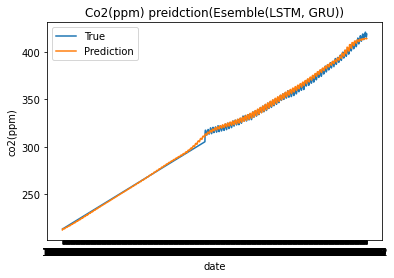

In [62]:
#x축 date(1900-01 ~ 2022-12) y축 co2(ppm)인 true값 그래프와 Ensemble모델(LSTM, GRU) 예측값 그래프 생성
plt.plot(co2.ID.values[seq_length:],co2['co2(ppm)'][seq_length:], label = 'True')
plt.plot(co2.ID.values[seq_length:], model_5(torch.FloatTensor(X_seq)).cpu().detach().numpy()[:-1], label = 'Prediction')
plt.xlabel('date')
plt.ylabel('co2(ppm)')
plt.title('Co2(ppm) preidction(Esemble(LSTM, GRU))')
plt.legend()
plt.show()

In [64]:
test_loss = [validation(model_1, test_dataloader, loss_func_1, device),
            validation(model_2, test_dataloader, loss_func_2, device),
            validation(model_3, test_dataloader, loss_func_3, device),
            validation(model_4, test_dataloader, loss_func_4, device),
            validation(model_5, test_dataloader, loss_func_5, device)]

In [65]:
model_name = ["RNN", "LSTM", "GRU", "Ensemble(RNN, LSTM, GRU)", "Ensemble(LSTM, GRU)"]

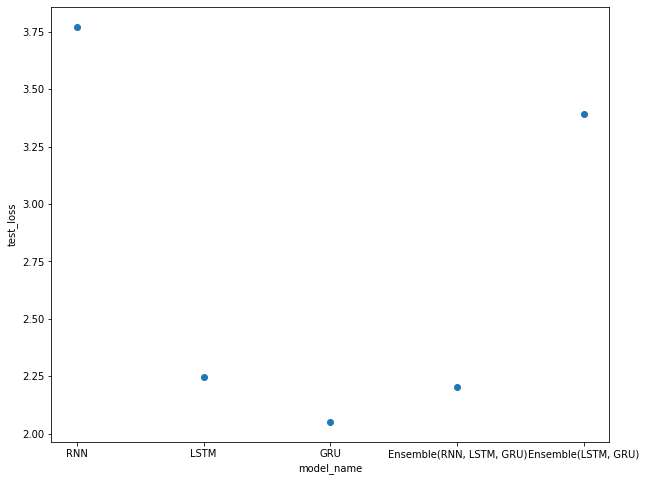

In [66]:
#model별 test loss를 plot
plt.figure(figsize=(10,8))
plt.scatter(model_name, test_loss)
plt.xlabel("model_name")
plt.ylabel("test_loss")
plt.show()

In [67]:
#모델예측을 위한 연,월 및 주 데이터 생성
#지금 seq_length가 12이므로 1월부터~12월까지의 데이터를 이용해 다음해 1월의 co2 예측하므로 2022년 데이터까지 사용
X_2022_to_2032 = np.array([])
for year in range(2022, 2032 + 1):
    for month in range(1, 13):
        X_2022_to_2032 = np.append(X_2022_to_2032, np.array([year, month]))

In [68]:
X_2022_to_2032 = X_2022_to_2032.reshape(-1, 2).astype(int)

In [70]:
#데이터 스케일링
X_2022_to_2032_scaled = scaler.transform(X_2022_to_2032)

In [71]:
#데이터를 sequence length만큼 이어줌
X_2022_to_2032_scaled_seq = data_to_seq(X_2022_to_2032_scaled, X_2022_to_2032_scaled.shape[1], seq_length)[:-1]

In [73]:
#유가 예측값
#3번째 모델(GRU)의 test loss가 가장 작으므로 3번째 모델로 예측
co2_2023_to_2032 = model_3(torch.FloatTensor(X_2022_to_2032_scaled_seq)).cpu().detach().numpy()

In [75]:
X_2022_to_2032_df = pd.DataFrame(X_2022_to_2032)

In [83]:
#input데이터와 output데이터 합침
pred_2023_to_2032 = pd.DataFrame(np.hstack((X_2022_to_2032_df[X_2022_to_2032_df[0] != 2022].values,
                                            co2_2023_to_2032.reshape(-1,1))), columns = ['Year', 'Month', 'co2(ppm)'])

In [84]:
pred_2023_to_2032['Year'] = pred_2023_to_2032['Year'].astype(int)
pred_2023_to_2032['Month'] = pred_2023_to_2032['Month'].astype(int)

In [85]:
#연, 월 column으로 id column 생성
pred_2023_to_2032['ID'] = pred_2023_to_2032['Year'].astype(str) + '-' + pred_2023_to_2032['Month'].apply(lambda x: str(x).zfill(2))

In [86]:
pred_2023_to_2032.drop(columns = ['Year', 'Month']).to_csv("/Users/jeonghongjun/python_project/AI_project/data/co2_2023_to_2032.csv")

In [87]:
torch.save(model_3, "/Users/jeonghongjun/python_project/AI_project/model/co2_model(GRU).pth")